# How does he saw me? Hero selection

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from matplotlib.pyplot import figure


import gc
from subprocess import check_output


from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor

from sklearn.utils import check_array
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Model assement functionality
from sklearn.model_selection import LeaveOneOut, KFold, train_test_split, cross_val_score

from sklearn.neural_network import MLPClassifier

### Different Game modes table

### Game Modes
| id | Name                   |
|----|------------------------|
| 0  | No Game Mode           |
| 1  | All Pick               |
| 2  | Captain's Mode         |
| 3  | Random Draft           |
| 4  | Single Draft           |
| 5  | All Random             |
| 7  | Diretide               |
| 8  | Reverse Captain's Mode |
| 9  | Greeviling             |
| 10 | Tutorial               |
| 11 | Mid Only               |
| 12 | Least Played           |
| 13 | New Player Pool        |
| 14 | Compendium Matchmaking |
| 15 | Custom                 |
| 16 | Captain's Draft        |
| 17 | Balanced Draft         |
| 18 | Ability Draft          |
| 20 | All Random Deathmatch  |
| 21 | Solo Mid 1v1           |
| 22 | Ranked All Pick        |

### Data import

In [140]:
players_data = pd.read_csv("./data/players.csv")
player_time_data = pd.read_csv('./data/player_time.csv')
matches_data = pd.read_csv("./data/match.csv")

### Data Prep\Cleansing

In [150]:
# Convert the timestamp to date
matches_data['start_time'] = pd.to_datetime(matches_data['start_time'], unit='s')

# filter only games where no player left the game
players_data = players_data[players_data.leaver_status == 0]


### Assumptions
* No players leave before the match is over
* Players are in the same group of skill
* The skill of the players is high

account_id is useful if you want to look at multiple matches for the same player but be aware that many players choose to hide their account_id so it won't be available.

In [153]:
# merge players_data with matches
df = pd.merge(players_data, matches_data, on='match_id')

### Data exploration

In [4]:
players_data.account_id.value_counts()

0         181169
2701          71
2362          60
10307         59
18680         59
           ...  
100933         1
102982         1
105031         1
125513         1
106316         1
Name: account_id, Length: 158361, dtype: int64

##### Many players hide their ids, that's why there are so many 0s. 181169 out of 500k are not available

### Heroes table

## Heroes

| id  | name                                    | localized\_name     | primary\_attr | attack\_type | roles                                           | legs |
|-----|-----------------------------------------|---------------------|---------------|--------------|-------------------------------------------------|------|
| 1   | npc\_dota\_hero\_antimage               | Anti\-Mage          | agi           | Melee        | Carry,Escape,Nuker                              | 2    |
| 2   | npc\_dota\_hero\_axe                    | Axe                 | str           | Melee        | Initiator,Durable,Disabler,Jungler              | 2    |
| 3   | npc\_dota\_hero\_bane                   | Bane                | int           | Ranged       | Support,Disabler,Nuker,Durable                  | 4    |
| 4   | npc\_dota\_hero\_bloodseeker            | Bloodseeker         | agi           | Melee        | Carry,Disabler,Jungler,Nuker,Initiator          | 2    |
| 5   | npc\_dota\_hero\_crystal\_maiden        | Crystal Maiden      | int           | Ranged       | Support,Disabler,Nuker,Jungler                  | 2    |
| 6   | npc\_dota\_hero\_drow\_ranger           | Drow Ranger         | agi           | Ranged       | Carry,Disabler,Pusher                           | 2    |
| 7   | npc\_dota\_hero\_earthshaker            | Earthshaker         | str           | Melee        | Support,Initiator,Disabler,Nuker                | 2    |
| 8   | npc\_dota\_hero\_juggernaut             | Juggernaut          | agi           | Melee        | Carry,Pusher,Escape                             | 2    |
| 9   | npc\_dota\_hero\_mirana                 | Mirana              | agi           | Ranged       | Carry,Support,Escape,Nuker,Disabler             | 2    |
| 10  | npc\_dota\_hero\_morphling              | Morphling           | agi           | Ranged       | Carry,Escape,Durable,Nuker,Disabler             | 0    |
| 11  | npc\_dota\_hero\_nevermore              | Shadow Fiend        | agi           | Ranged       | Carry,Nuker                                     | 0    |
| 12  | npc\_dota\_hero\_phantom\_lancer        | Phantom Lancer      | agi           | Melee        | Carry,Escape,Pusher,Nuker                       | 2    |
| 13  | npc\_dota\_hero\_puck                   | Puck                | int           | Ranged       | Initiator,Disabler,Escape,Nuker                 | 2    |
| 14  | npc\_dota\_hero\_pudge                  | Pudge               | str           | Melee        | Disabler,Initiator,Durable,Nuker                | 2    |
| 15  | npc\_dota\_hero\_razor                  | Razor               | agi           | Ranged       | Carry,Durable,Nuker,Pusher                      | 0    |
| 16  | npc\_dota\_hero\_sand\_king             | Sand King           | str           | Melee        | Initiator,Disabler,Support,Nuker,Escape,Jungler | 6    |
| 17  | npc\_dota\_hero\_storm\_spirit          | Storm Spirit        | int           | Ranged       | Carry,Escape,Nuker,Initiator,Disabler           | 2    |
| 18  | npc\_dota\_hero\_sven                   | Sven                | str           | Melee        | Carry,Disabler,Initiator,Durable,Nuker          | 2    |
| 19  | npc\_dota\_hero\_tiny                   | Tiny                | str           | Melee        | Carry,Nuker,Pusher,Initiator,Durable,Disabler   | 2    |
| 20  | npc\_dota\_hero\_vengefulspirit         | Vengeful Spirit     | agi           | Ranged       | Support,Initiator,Disabler,Nuker,Escape         | 2    |
| 21  | npc\_dota\_hero\_windrunner             | Windranger          | int           | Ranged       | Carry,Support,Disabler,Escape,Nuker             | 2    |
| 22  | npc\_dota\_hero\_zuus                   | Zeus                | int           | Ranged       | Nuker                                           | 2    |
| 23  | npc\_dota\_hero\_kunkka                 | Kunkka              | str           | Melee        | Carry,Support,Disabler,Initiator,Durable,Nuker  | 2    |
| 25  | npc\_dota\_hero\_lina                   | Lina                | int           | Ranged       | Support,Carry,Nuker,Disabler                    | 2    |
| 26  | npc\_dota\_hero\_lion                   | Lion                | int           | Ranged       | Support,Disabler,Nuker,Initiator                | 2    |
| 27  | npc\_dota\_hero\_shadow\_shaman         | Shadow Shaman       | int           | Ranged       | Support,Pusher,Disabler,Nuker,Initiator         | 2    |
| 28  | npc\_dota\_hero\_slardar                | Slardar             | str           | Melee        | Carry,Durable,Initiator,Disabler,Escape         | 0    |
| 29  | npc\_dota\_hero\_tidehunter             | Tidehunter          | str           | Melee        | Initiator,Durable,Disabler,Nuker                | 2    |
| 30  | npc\_dota\_hero\_witch\_doctor          | Witch Doctor        | int           | Ranged       | Support,Nuker,Disabler                          | 2    |
| 31  | npc\_dota\_hero\_lich                   | Lich                | int           | Ranged       | Support,Nuker                                   | 2    |
| 32  | npc\_dota\_hero\_riki                   | Riki                | agi           | Melee        | Carry,Escape,Disabler                           | 2    |
| 33  | npc\_dota\_hero\_enigma                 | Enigma              | int           | Ranged       | Disabler,Jungler,Initiator,Pusher               | 0    |
| 34  | npc\_dota\_hero\_tinker                 | Tinker              | int           | Ranged       | Carry,Nuker,Pusher                              | 2    |
| 35  | npc\_dota\_hero\_sniper                 | Sniper              | agi           | Ranged       | Carry,Nuker                                     | 2    |
| 36  | npc\_dota\_hero\_necrolyte              | Necrophos           | int           | Ranged       | Carry,Nuker,Durable,Disabler                    | 2    |
| 37  | npc\_dota\_hero\_warlock                | Warlock             | int           | Ranged       | Support,Initiator,Disabler                      | 2    |
| 38  | npc\_dota\_hero\_beastmaster            | Beastmaster         | str           | Melee        | Initiator,Disabler,Durable,Nuker                | 2    |
| 39  | npc\_dota\_hero\_queenofpain            | Queen of Pain       | int           | Ranged       | Carry,Nuker,Escape                              | 2    |
| 40  | npc\_dota\_hero\_venomancer             | Venomancer          | agi           | Ranged       | Support,Nuker,Initiator,Pusher,Disabler         | 0    |
| 41  | npc\_dota\_hero\_faceless\_void         | Faceless Void       | agi           | Melee        | Carry,Initiator,Disabler,Escape,Durable         | 2    |
| 42  | npc\_dota\_hero\_skeleton\_king         | Wraith King         | str           | Melee        | Carry,Support,Durable,Disabler,Initiator        | 2    |
| 43  | npc\_dota\_hero\_death\_prophet         | Death Prophet       | int           | Ranged       | Carry,Pusher,Nuker,Disabler                     | 2    |
| 44  | npc\_dota\_hero\_phantom\_assassin      | Phantom Assassin    | agi           | Melee        | Carry,Escape                                    | 2    |
| 45  | npc\_dota\_hero\_pugna                  | Pugna               | int           | Ranged       | Nuker,Pusher                                    | 2    |
| 46  | npc\_dota\_hero\_templar\_assassin      | Templar Assassin    | agi           | Ranged       | Carry,Escape                                    | 2    |
| 47  | npc\_dota\_hero\_viper                  | Viper               | agi           | Ranged       | Carry,Durable,Initiator,Disabler                | 0    |
| 48  | npc\_dota\_hero\_luna                   | Luna                | agi           | Ranged       | Carry,Nuker,Pusher                              | 2    |
| 49  | npc\_dota\_hero\_dragon\_knight         | Dragon Knight       | str           | Melee        | Carry,Pusher,Durable,Disabler,Initiator,Nuker   | 2    |
| 50  | npc\_dota\_hero\_dazzle                 | Dazzle              | int           | Ranged       | Support,Nuker,Disabler                          | 2    |
| 51  | npc\_dota\_hero\_rattletrap             | Clockwerk           | str           | Melee        | Initiator,Disabler,Durable,Nuker                | 2    |
| 52  | npc\_dota\_hero\_leshrac                | Leshrac             | int           | Ranged       | Carry,Support,Nuker,Pusher,Disabler             | 4    |
| 53  | npc\_dota\_hero\_furion                 | Nature's Prophet    | int           | Ranged       | Carry,Jungler,Pusher,Escape,Nuker               | 2    |
| 54  | npc\_dota\_hero\_life\_stealer          | Lifestealer         | str           | Melee        | Carry,Durable,Jungler,Escape,Disabler           | 2    |
| 55  | npc\_dota\_hero\_dark\_seer             | Dark Seer           | int           | Melee        | Initiator,Jungler,Escape,Disabler               | 2    |
| 56  | npc\_dota\_hero\_clinkz                 | Clinkz              | agi           | Ranged       | Carry,Escape,Pusher                             | 2    |
| 57  | npc\_dota\_hero\_omniknight             | Omniknight          | str           | Melee        | Support,Durable,Nuker                           | 2    |
| 58  | npc\_dota\_hero\_enchantress            | Enchantress         | int           | Ranged       | Support,Jungler,Pusher,Durable,Disabler         | 4    |
| 59  | npc\_dota\_hero\_huskar                 | Huskar              | str           | Ranged       | Carry,Durable,Initiator                         | 2    |
| 60  | npc\_dota\_hero\_night\_stalker         | Night Stalker       | str           | Melee        | Carry,Initiator,Durable,Disabler,Nuker          | 2    |
| 61  | npc\_dota\_hero\_broodmother            | Broodmother         | agi           | Melee        | Carry,Pusher,Escape,Nuker                       | 8    |
| 62  | npc\_dota\_hero\_bounty\_hunter         | Bounty Hunter       | agi           | Melee        | Escape,Nuker                                    | 2    |
| 63  | npc\_dota\_hero\_weaver                 | Weaver              | agi           | Ranged       | Carry,Escape                                    | 4    |
| 64  | npc\_dota\_hero\_jakiro                 | Jakiro              | int           | Ranged       | Support,Nuker,Pusher,Disabler                   | 2    |
| 65  | npc\_dota\_hero\_batrider               | Batrider            | int           | Ranged       | Initiator,Jungler,Disabler,Escape               | 2    |
| 66  | npc\_dota\_hero\_chen                   | Chen                | int           | Ranged       | Support,Jungler,Pusher                          | 2    |
| 67  | npc\_dota\_hero\_spectre                | Spectre             | agi           | Melee        | Carry,Durable,Escape                            | 0    |
| 68  | npc\_dota\_hero\_ancient\_apparition    | Ancient Apparition  | int           | Ranged       | Support,Disabler,Nuker                          | 2    |
| 69  | npc\_dota\_hero\_doom\_bringer          | Doom                | str           | Melee        | Carry,Disabler,Initiator,Durable,Nuker          | 2    |
| 70  | npc\_dota\_hero\_ursa                   | Ursa                | agi           | Melee        | Carry,Jungler,Durable,Disabler                  | 2    |
| 71  | npc\_dota\_hero\_spirit\_breaker        | Spirit Breaker      | str           | Melee        | Carry,Initiator,Disabler,Durable,Escape         | 2    |
| 72  | npc\_dota\_hero\_gyrocopter             | Gyrocopter          | agi           | Ranged       | Carry,Nuker,Disabler                            | 2    |
| 73  | npc\_dota\_hero\_alchemist              | Alchemist           | str           | Melee        | Carry,Support,Durable,Disabler,Initiator,Nuker  | 2    |
| 74  | npc\_dota\_hero\_invoker                | Invoker             | int           | Ranged       | Carry,Nuker,Disabler,Escape,Pusher              | 2    |
| 75  | npc\_dota\_hero\_silencer               | Silencer            | int           | Ranged       | Carry,Support,Disabler,Initiator,Nuker          | 2    |
| 76  | npc\_dota\_hero\_obsidian\_destroyer    | Outworld Devourer   | int           | Ranged       | Carry,Nuker,Disabler                            | 4    |
| 77  | npc\_dota\_hero\_lycan                  | Lycan               | str           | Melee        | Carry,Pusher,Jungler,Durable,Escape             | 2    |
| 78  | npc\_dota\_hero\_brewmaster             | Brewmaster          | str           | Melee        | Carry,Initiator,Durable,Disabler,Nuker          | 2    |
| 79  | npc\_dota\_hero\_shadow\_demon          | Shadow Demon        | int           | Ranged       | Support,Disabler,Initiator,Nuker                | 2    |
| 80  | npc\_dota\_hero\_lone\_druid            | Lone Druid          | agi           | Ranged       | Carry,Pusher,Jungler,Durable                    | 2    |
| 81  | npc\_dota\_hero\_chaos\_knight          | Chaos Knight        | str           | Melee        | Carry,Disabler,Durable,Pusher,Initiator         | 2    |
| 82  | npc\_dota\_hero\_meepo                  | Meepo               | agi           | Melee        | Carry,Escape,Nuker,Disabler,Initiator,Pusher    | 2    |
| 83  | npc\_dota\_hero\_treant                 | Treant Protector    | str           | Melee        | Support,Initiator,Durable,Disabler,Escape       | 2    |
| 84  | npc\_dota\_hero\_ogre\_magi             | Ogre Magi           | int           | Melee        | Support,Nuker,Disabler,Durable,Initiator        | 2    |
| 85  | npc\_dota\_hero\_undying                | Undying             | str           | Melee        | Support,Durable,Disabler,Nuker                  | 2    |
| 86  | npc\_dota\_hero\_rubick                 | Rubick              | int           | Ranged       | Support,Disabler,Nuker                          | 2    |
| 87  | npc\_dota\_hero\_disruptor              | Disruptor           | int           | Ranged       | Support,Disabler,Nuker,Initiator                | 2    |
| 88  | npc\_dota\_hero\_nyx\_assassin          | Nyx Assassin        | agi           | Melee        | Disabler,Nuker,Initiator,Escape                 | 6    |
| 89  | npc\_dota\_hero\_naga\_siren            | Naga Siren          | agi           | Melee        | Carry,Support,Pusher,Disabler,Initiator,Escape  | 0    |
| 90  | npc\_dota\_hero\_keeper\_of\_the\_light | Keeper of the Light | int           | Ranged       | Support,Nuker,Disabler,Jungler                  | 2    |
| 91  | npc\_dota\_hero\_wisp                   | Io                  | str           | Ranged       | Support,Escape,Nuker                            | 0    |
| 92  | npc\_dota\_hero\_visage                 | Visage              | int           | Ranged       | Support,Nuker,Durable,Disabler,Pusher           | 2    |
| 93  | npc\_dota\_hero\_slark                  | Slark               | agi           | Melee        | Carry,Escape,Disabler,Nuker                     | 2    |
| 94  | npc\_dota\_hero\_medusa                 | Medusa              | agi           | Ranged       | Carry,Disabler,Durable                          | 0    |
| 95  | npc\_dota\_hero\_troll\_warlord         | Troll Warlord       | agi           | Ranged       | Carry,Pusher,Disabler,Durable                   | 2    |
| 96  | npc\_dota\_hero\_centaur                | Centaur Warrunner   | str           | Melee        | Durable,Initiator,Disabler,Nuker,Escape         | 4    |
| 97  | npc\_dota\_hero\_magnataur              | Magnus              | str           | Melee        | Initiator,Disabler,Nuker,Escape                 | 4    |
| 98  | npc\_dota\_hero\_shredder               | Timbersaw           | str           | Melee        | Nuker,Durable,Escape                            | 2    |
| 99  | npc\_dota\_hero\_bristleback            | Bristleback         | str           | Melee        | Carry,Durable,Initiator,Nuker                   | 2    |
| 100 | npc\_dota\_hero\_tusk                   | Tusk                | str           | Melee        | Initiator,Disabler,Nuker                        | 2    |
| 101 | npc\_dota\_hero\_skywrath\_mage         | Skywrath Mage       | int           | Ranged       | Support,Nuker,Disabler                          | 2    |
| 102 | npc\_dota\_hero\_abaddon                | Abaddon             | str           | Melee        | Support,Carry,Durable                           | 2    |
| 103 | npc\_dota\_hero\_elder\_titan           | Elder Titan         | str           | Melee        | Initiator,Disabler,Nuker,Durable                | 2    |
| 104 | npc\_dota\_hero\_legion\_commander      | Legion Commander    | str           | Melee        | Carry,Disabler,Initiator,Durable,Nuker          | 2    |
| 105 | npc\_dota\_hero\_techies                | Techies             | int           | Ranged       | Nuker,Disabler                                  | 6    |
| 106 | npc\_dota\_hero\_ember\_spirit          | Ember Spirit        | agi           | Melee        | Carry,Escape,Nuker,Disabler,Initiator           | 2    |
| 107 | npc\_dota\_hero\_earth\_spirit          | Earth Spirit        | str           | Melee        | Nuker,Escape,Disabler,Initiator,Durable         | 2    |
| 108 | npc\_dota\_hero\_abyssal\_underlord     | Underlord           | str           | Melee        | Support,Nuker,Disabler,Durable,Escape           | 2    |
| 109 | npc\_dota\_hero\_terrorblade            | Terrorblade         | agi           | Melee        | Carry,Pusher,Nuker                              | 2    |
| 110 | npc\_dota\_hero\_phoenix                | Phoenix             | str           | Ranged       | Support,Nuker,Initiator,Escape,Disabler         | 2    |
| 111 | npc\_dota\_hero\_oracle                 | Oracle              | int           | Ranged       | Support,Nuker,Disabler,Escape                   | 2    |
| 112 | npc\_dota\_hero\_winter\_wyvern         | Winter Wyvern       | int           | Ranged       | Support,Disabler,Nuker                          | 2    |
| 113 | npc\_dota\_hero\_arc\_warden            | Arc Warden          | agi           | Ranged       | Carry,Escape,Nuker                              | 2    |
| 114 | npc\_dota\_hero\_monkey\_king           | Monkey King         | agi           | Melee        | Carry,Escape,Disabler,Initiator                 | 2    |
| 119 | npc\_dota\_hero\_dark\_willow           | Dark Willow         | int           | Ranged       | Support,Nuker,Disabler,Escape                   | 2    |
| 120 | npc\_dota\_hero\_pangolier              | Pangolier           | agi           | Melee        | Carry,Nuker,Disabler,Durable,Escape,Initiator   | 2    |
| 121 | npc\_dota\_hero\_grimstroke             | Grimstroke          | int           | Ranged       | Support,Nuker,Disabler,Escape                   | 2    |
| 126 | npc\_dota\_hero\_void\_spirit           | Void Spirit         | int           | Melee        | Carry,Escape,Nuker,Disabler                     | 2    |
| 128 | npc\_dota\_hero\_snapfire               | Snapfire            | str           | Ranged       | Support,Nuker,Disabler,Escape                   | 2    |
| 129 | npc\_dota\_hero\_mars                   | Mars                | str           | Melee        | Carry,Initiator,Disabler,Durable                | 2    |


### Match table

| description                                                                                                                                                                                     | type    |                           |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------|---------------------------|
| The ID number of the match assigned by Valve                                                                                                                                                    | integer | match\_id                 |
| Bitmask\. An integer that represents a binary of which barracks are still standing\. 63 would mean all barracks still stand at the end of the game\.                                            | integer | barracks\_status\_dire    |
| Bitmask\. An integer that represents a binary of which barracks are still standing\. 63 would mean all barracks still stand at the end of the game\.                                            | integer | barracks\_status\_radiant |
| Array containing information on the chat of the game                                                                                                                                            | array   | \[object Object\]         | chat           |
| cluster                                                                                                                                                                                         | integer | cluster                   |
| cosmetics                                                                                                                                                                                       | object  | cosmetics                 |
| Final score for Dire \(number of kills on Radiant\)                                                                                                                                             | integer | dire\_score               |
| draft\_timings                                                                                                                                                                                  | array   | \[object Object\]         | draft\_timings |
| Duration of the game in seconds                                                                                                                                                                 | integer | duration                  |
| engine                                                                                                                                                                                          | integer | engine                    |
| Time in seconds at which first blood occurred                                                                                                                                                   | integer | first\_blood\_time        |
| Integer corresponding to game mode played\. List of constants can be found here: https://github\.com/odota/dotaconstants/blob/master/json/game\_mode\.json                                      | integer | game\_mode                |
| Number of human players in the game                                                                                                                                                             | integer | human\_players            |
| leagueid                                                                                                                                                                                        | integer | leagueid                  |
| Integer corresponding to lobby type of match\. List of constants can be found here: https://github\.com/odota/dotaconstants/blob/master/json/lobby\_type\.json                                  | integer | lobby\_type               |
| match\_seq\_num                                                                                                                                                                                 | integer | match\_seq\_num           |
| Number of negative votes the replay received in the in\-game client                                                                                                                             | integer | negative\_votes           |
| objectives                                                                                                                                                                                      | object  | objectives                |
| Object containing information on the draft\. Each pick/ban contains a boolean relating to whether the choice is a pick or a ban, the hero ID, the team the picked or banned it, and the order\. | object  | picks\_bans               |
| Number of positive votes the replay received in the in\-game client                                                                                                                             | integer | positive\_votes           |
| Array of the Radiant gold advantage at each minute in the game\. A negative number means that Radiant is behind, and thus it is their gold disadvantage\.                                       | object  | radiant\_gold\_adv        |
| Final score for Radiant \(number of kills on Radiant\)                                                                                                                                          | integer | radiant\_score            |
| Boolean indicating whether Radiant won the match                                                                                                                                                | boolean | radiant\_win              |
| Array of the Radiant experience advantage at each minute in the game\. A negative number means that Radiant is behind, and thus it is their experience disadvantage\.                           | object  | radiant\_xp\_adv          |
| The Unix timestamp at which the game started                                                                                                                                                    | integer | start\_time               |
| teamfights                                                                                                                                                                                      | object  | teamfights                |
| Bitmask\. An integer that represents a binary of which Dire towers are still standing\.                                                                                                         | integer | tower\_status\_dire       |
| Bitmask\. An integer that represents a binary of which Radiant towers are still standing\.                                                                                                      | integer | tower\_status\_radiant    |
| Parse version, used internally by OpenDota                                                                                                                                                      | integer | version                   |
| replay\_salt                                                                                                                                                                                    | integer | replay\_salt              |
| series\_id                                                                                                                                                                                      | integer | series\_id                |
| series\_type                                                                                                                                                                                    | integer | series\_type              |
| radiant\_team                                                                                                                                                                                   | object  | radiant\_team             |
| dire\_team                                                                                                                                                                                      | object  | dire\_team                |
| league                                                                                                                                                                                          | object  | league                    |
| Skill bracket assigned by Valve \(Normal, High, Very High\)                                                                                                                                     | integer | skill                     |
| Array of information on individual players                                                                                                                                                      | array   | \[object Object\]         | players        |
| Information on the patch version the game is played on                                                                                                                                          | integer | patch                     |
| Integer corresponding to the region the game was played on                                                                                                                                      | integer | region                    |
| Word counts of the all chat messages in the player's games                                                                                                                                      | object  | all\_word\_counts         |
| Word counts of the player's all chat messages                                                                                                                                                   | object  | my\_word\_counts          |
| Maximum gold advantage of the player's team if they lost the match                                                                                                                              | integer | throw                     |
| Maximum gold disadvantage of the player's team if they won the match                                                                                                                            | integer | comeback                  |
| Maximum gold disadvantage of the player's team if they lost the match                                                                                                                           | integer | loss                      |
| Maximum gold advantage of the player's team if they won the match                                                                                                                               | integer | win                       |
| replay\_url                                                                                                                                                                                     | string  | replay\_url               |


### Players schema

In [121]:
players_schema = pd.read_json("./schemas/players.json")
columns_titles = ['key', 'type', 'description']
players_schema = players_schema.reindex(columns=columns_titles)
pd.options.display.max_colwidth = 100
players_schema[60:120]

,key,type,description
60,purchase,object,Object containing information on the items the player purchased
61,purchase_log,array,Object containing information on when items were purchased
62,rune_pickups,integer,Number of runes picked up
63,runes,object,Object with information about which runes the player picked up
64,runes_log,array,Array with information on when runes were picked up
65,sen,object,Object with information on where sentries were placed. The location takes the form (outer number...
66,sen_left_log,array,Array containing information on when and where the player placed sentries
67,sen_log,array,Array with information on when and where sentries were placed by the player
68,sen_placed,integer,How many sentries were placed by the player
69,stuns,number,Total stun duration of all stuns by the player


In [160]:
a_match = player_time_data[player_time_data['match_id'] == 1]
# a_match.T

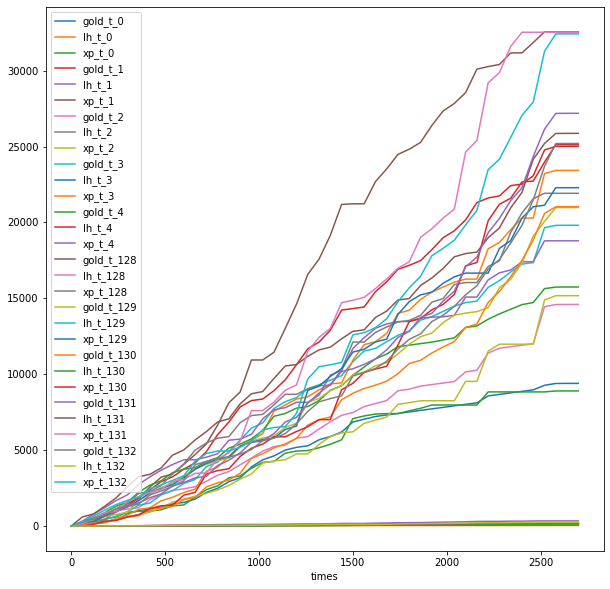

In [161]:
a_match.iloc[:, 1:].plot.line(x='times', figsize=(10, 10));

In [81]:
import datetime
timestamp = datetime.datetime.fromtimestamp(1446750112)
print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))


2015-11-05 21:01:52


<AxesSubplot:xlabel='start_time', ylabel='gold_per_min'>

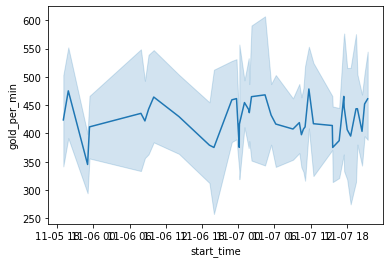

In [159]:
# sns.lineplot(data=df.sort_values(by='start_time')[:400], x='start_time', y='gold_per_min')